In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.insert(0, '../')

In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

## Detecting faces

code based on dlib align of open face

Use `dlib's landmark estimation <http://blog.dlib.net/2014/08/real-time-face-pose-estimation.html>`_ to align faces.
    The alignment preprocess faces for input into a neural network.
    Faces are resized to the same size (such as 96x96) and transformed
    to make landmarks (such as the eyes and nose) appear at the same
    location on every image.
    Normalized landmarks:
    .. image:: ../images/dlib-landmark-mean.png

In [5]:
TEMPLATE = np.float32([
    (0.0792396913815, 0.339223741112), (0.0829219487236, 0.456955367943),
    (0.0967927109165, 0.575648016728), (0.122141515615, 0.691921601066),
    (0.168687863544, 0.800341263616), (0.239789390707, 0.895732504778),
    (0.325662452515, 0.977068762493), (0.422318282013, 1.04329000149),
    (0.531777802068, 1.06080371126), (0.641296298053, 1.03981924107),
    (0.738105872266, 0.972268833998), (0.824444363295, 0.889624082279),
    (0.894792677532, 0.792494155836), (0.939395486253, 0.681546643421),
    (0.96111933829, 0.562238253072), (0.970579841181, 0.441758925744),
    (0.971193274221, 0.322118743967), (0.163846223133, 0.249151738053),
    (0.21780354657, 0.204255863861), (0.291299351124, 0.192367318323),
    (0.367460241458, 0.203582210627), (0.4392945113, 0.233135599851),
    (0.586445962425, 0.228141644834), (0.660152671635, 0.195923841854),
    (0.737466449096, 0.182360984545), (0.813236546239, 0.192828009114),
    (0.8707571886, 0.235293377042), (0.51534533827, 0.31863546193),
    (0.516221448289, 0.396200446263), (0.517118861835, 0.473797687758),
    (0.51816430343, 0.553157797772), (0.433701156035, 0.604054457668),
    (0.475501237769, 0.62076344024), (0.520712933176, 0.634268222208),
    (0.565874114041, 0.618796581487), (0.607054002672, 0.60157671656),
    (0.252418718401, 0.331052263829), (0.298663015648, 0.302646354002),
    (0.355749724218, 0.303020650651), (0.403718978315, 0.33867711083),
    (0.352507175597, 0.349987615384), (0.296791759886, 0.350478978225),
    (0.631326076346, 0.334136672344), (0.679073381078, 0.29645404267),
    (0.73597236153, 0.294721285802), (0.782865376271, 0.321305281656),
    (0.740312274764, 0.341849376713), (0.68499850091, 0.343734332172),
    (0.353167761422, 0.746189164237), (0.414587777921, 0.719053835073),
    (0.477677654595, 0.706835892494), (0.522732900812, 0.717092275768),
    (0.569832064287, 0.705414478982), (0.635195811927, 0.71565572516),
    (0.69951672331, 0.739419187253), (0.639447159575, 0.805236879972),
    (0.576410514055, 0.835436670169), (0.525398405766, 0.841706377792),
    (0.47641545769, 0.837505914975), (0.41379548902, 0.810045601727),
    (0.380084785646, 0.749979603086), (0.477955996282, 0.74513234612),
    (0.523389793327, 0.748924302636), (0.571057789237, 0.74332894691),
    (0.672409137852, 0.744177032192), (0.572539621444, 0.776609286626),
    (0.5240106503, 0.783370783245), (0.477561227414, 0.778476346951)])

TPL_MIN, TPL_MAX = np.min(TEMPLATE, axis=0), np.max(TEMPLATE, axis=0)
MINMAX_TEMPLATE = (TEMPLATE - TPL_MIN) / (TPL_MAX - TPL_MIN)

In [6]:
INNER_EYES_AND_BOTTOM_LIP = [39, 42, 57]
OUTER_EYES_AND_NOSE = [36, 45, 33]

(1.0, 0.0)

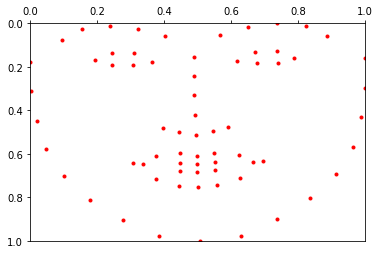

In [7]:
plt.plot(MINMAX_TEMPLATE[:, 0], MINMAX_TEMPLATE[:, 1], 'r.')
ax=plt.gca()                            # get the axis
ax.xaxis.tick_top()                     # and move the X-Axis      
ax.yaxis.tick_left()  
ax.set_xlim([0.0, 1.0])
ax.set_ylim([1.0, 0.0])

In [8]:
def align(out_size, image, landmarks, indices=INNER_EYES_AND_BOTTOM_LIP):

    landmarks = np.asarray(landmarks, dtype=np.float32)
    H = cv2.getAffineTransform(landmarks[indices],
                               out_size * MINMAX_TEMPLATE[indices])
    
    thumbnail = cv2.warpAffine(image, H, (out_size, out_size))

    return thumbnail

In [9]:
def rect_to_tuple(rect):
    return rect.left(), rect.top(), rect.right(), rect.bottom()

In [10]:
def increase_img_size(img, bbox):
        """ this method increases the bounding box size
        if start and end values for the bounding box
        go beyond the image size (from either side)
        and in such a case gets the ratio of padded region
        to the total image size (total_img_size = orig_size + pad)
        """

        x_start, y_start, width_bbox, height_bbox = bbox
        x_end = x_start + width_bbox
        y_end = y_start + height_bbox

        height, width = img.shape[:2]

        x_extra_start = 0
        x_extra_end = 0
        y_extra_start = 0
        y_extra_end = 0

        if x_start < 0:
            x_extra_start = - x_start
        if x_end > width:
            x_extra_end = x_end - width
        if y_start < 0:
            y_extra_start = - y_start
        if y_end > height:
            y_extra_end = y_end - height
            
        expand_img = cv2.copyMakeBorder(img,y_extra_start,y_extra_end,
                                        x_extra_start,x_extra_end,
                                        cv2.BORDER_CONSTANT,value=[0,0,0])

        # checking bounding box size after image padding
        height, width = expand_img.shape[:2]

        if x_extra_start:
            x_start = 0
            x_end += x_extra_start
        if y_extra_start:
            y_start = 0
            y_end += y_extra_start
        if x_extra_end:
            x_end = width
        if y_extra_end:
            y_end = height

        bbox_width = x_end - x_start
        bbox_height = y_end - y_start

        assert bbox_width == bbox_height

        expanded_rect = [x_start, y_start, bbox_width, bbox_height]

        return expand_img, expanded_rect, x_extra_start, y_extra_start

In [11]:
from cpe775.model import Model
from cpe775.networks.resnet import resnet18
import torch

In [12]:
net = resnet18(in_shape=(-1, 1, 256, 256), out_shape=(-1, 68, 2))
net = torch.nn.DataParallel(net)
net.cuda()
ckpt = torch.load('../results/resnet/resnet-18-1c-nrmse.pth-best.tar')

In [13]:
best_model = Model(net)
best_net = best_model.net
best_net.load_state_dict(ckpt['state_dict'])

In [14]:
import glob
import cv2
import dlib

from skimage import io

from cpe775.utils.img_utils import enlarge_bbox, get_bbox, get_bbox_from_landmarks

In [15]:
# Create a HOG face detector using the built-in dlib class
face_detector = dlib.get_frontal_face_detector()

Found 1 faces in the image file ../data/pics/IMG_20171214_172211.jpg
- Face #0 found at Left: 171 Top: 172 Right: 726 Bottom: 726


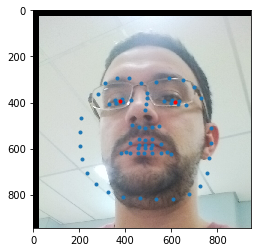

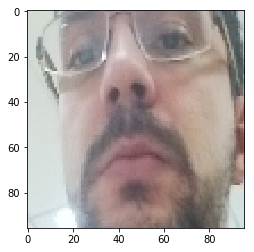

Found 1 faces in the image file ../data/pics/IMG_20171214_172209.jpg
- Face #0 found at Left: 233 Top: 357 Right: 788 Bottom: 911


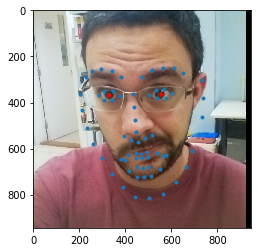

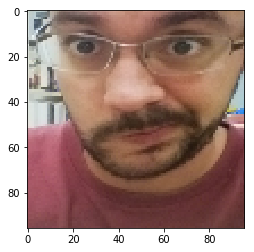

Found 1 faces in the image file ../data/pics/IMG_20171214_172206.jpg
- Face #0 found at Left: 110 Top: 233 Right: 664 Bottom: 788


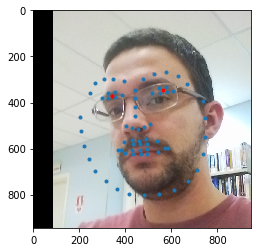

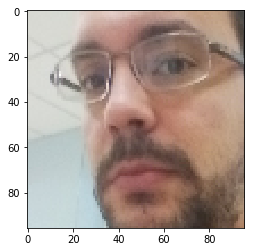

Found 1 faces in the image file ../data/pics/IMG_20171214_172203.jpg
- Face #0 found at Left: 245 Top: 297 Right: 707 Bottom: 759


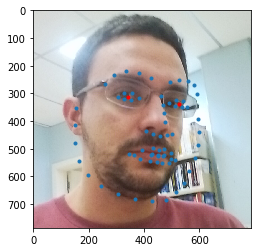

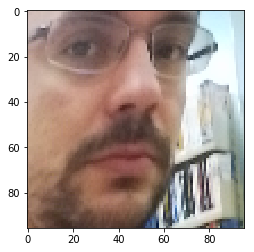

Found 1 faces in the image file ../data/pics/IMG_20171214_172201.jpg
- Face #0 found at Left: 297 Top: 297 Right: 759 Bottom: 759


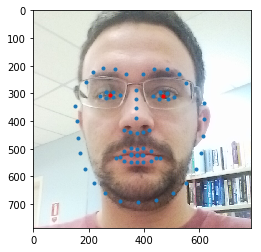

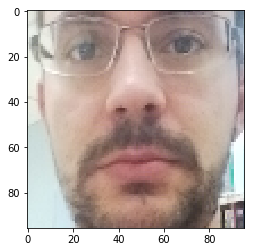

Found 1 faces in the image file ../data/pics/IMG_20171214_172159.jpg
- Face #0 found at Left: 245 Top: 297 Right: 707 Bottom: 759


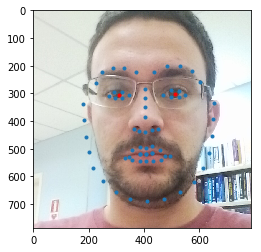

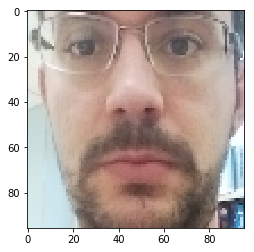

In [16]:

for f in glob.glob('../data/pics/*'):

    if f[-4:].lower() not in ('.jpg', '.png', 'jpeg'):
        continue

    # Load the image
    image = cv2.imread(f)

    # Run the HOG face detector on the image data
    detected_faces = face_detector(image, 1)

    print("Found {} faces in the image file {}".format(len(detected_faces), f))

    # Loop through each face we found in the image
    for i, face_rect in enumerate(detected_faces):

        # Detected faces are returned as an object with the coordinates 
        # of the top, left, right and bottom edges
        print("- Face #{} found at Left: {} Top: {} Right: {} Bottom: {}".format(i, face_rect.left(), face_rect.top(), face_rect.right(), face_rect.bottom()))


        bbox = get_bbox(*rect_to_tuple(face_rect))

        large_bbox = enlarge_bbox(bbox, 1.7)

        image, large_bbox, _, _ = increase_img_size(image, large_bbox)

        left, top, w, h = large_bbox

        color_cropped_image = image[top:top + h, left:left + w, :]
        cropped_image = cv2.cvtColor(color_cropped_image, cv2.COLOR_BGR2GRAY)
        cropped_image = cv2.resize(cropped_image, (224,224), interpolation = cv2.INTER_CUBIC)/255

        landmarks = best_model.predict(cropped_image[np.newaxis, np.newaxis, ...])[0, ...]

        plt.figure()
        plt.imshow(image[top:top + h, left:left + w,::-1])
        plt.plot(landmarks[:, 0] * w, landmarks[:, 1] * h, '.')

        left_eye = np.mean(landmarks[range(36,42), :], axis=-2)
        right_eye = np.mean(landmarks[range(42,48), :] , axis=-2)

        plt.plot(left_eye[0] * w, left_eye[1] * h, 'r.')
        plt.plot(right_eye[0] * w, right_eye[1] * h, 'r.')
        plt.show()

        thumbnail = align(96, image, landmarks * [w, h] + [left, top], indices=INNER_EYES_AND_BOTTOM_LIP)

        plt.figure()
        plt.imshow(thumbnail[:,:,::-1])
        plt.show()

        path, name = os.path.split(os.path.abspath(f))
        name, ext = os.path.splitext(name)

        if not os.path.isdir(os.path.join(path, 'cropped')):
            os.makedirs(os.path.join(path, 'cropped'))

        cv2.imwrite(os.path.join(path, 'cropped', '{}-{}{}'.format(name, i,  ext)), thumbnail)